Fitting 3 folds for each of 108 candidates, totalling 324 fits


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:18:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


最佳参数： {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


最佳阈值: 0.90, F1: 0.7121


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


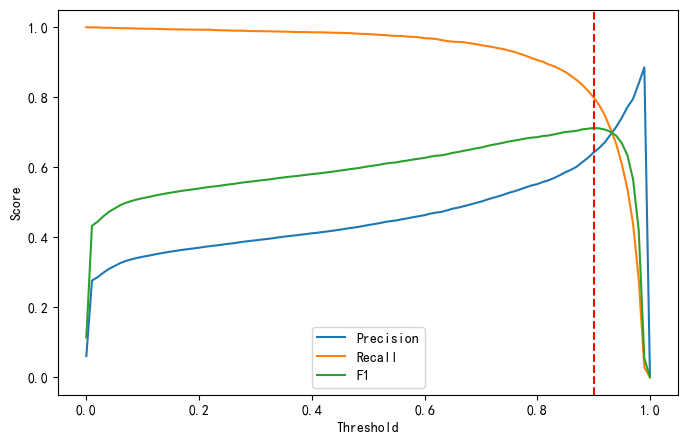


训练集 混淆矩阵:
[[233845   6691]
 [  3147  12317]]
训练集 分类报告:
              precision    recall  f1-score   support

           0     0.9867    0.9722    0.9794    240536
           1     0.6480    0.7965    0.7146     15464

    accuracy                         0.9616    256000
   macro avg     0.8174    0.8843    0.8470    256000
weighted avg     0.9663    0.9616    0.9634    256000

训练集 AUC: 0.9831

验证集 混淆矩阵:
[[58410  1724]
 [  775  3091]]
验证集 分类报告:
              precision    recall  f1-score   support

           0     0.9869    0.9713    0.9791     60134
           1     0.6420    0.7995    0.7121      3866

    accuracy                         0.9610     64000
   macro avg     0.8144    0.8854    0.8456     64000
weighted avg     0.9661    0.9610    0.9629     64000

验证集 AUC: 0.9827

测试集 混淆矩阵:
[[73095  2073]
 [  985  3847]]
测试集 分类报告:
              precision    recall  f1-score   support

           0     0.9867    0.9724    0.9795     75168
           1     0.6498    0.7962    0.7156  

In [7]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

# 配置绘图环境，解决中文乱码和负号问题
import matplotlib
matplotlib.rcParams['font.family'] = 'SimHei'
matplotlib.rcParams['axes.unicode_minus'] = False

# -------------------- 1. 读取数据 --------------------
file_path = r'D:\桌面\2025年第四届“创新杯”（原钉钉杯）大学生大数据挑战赛初赛题目\2025年第四届“创新杯”（原钉钉杯）大学生大数据挑战赛初赛题目\A题\data\train_data.csv'
df = pd.read_csv(file_path)

# -------------------- 2. 数据清洗 --------------------
high_missing_cols = ['Laser_Intensity', 'Hydraulic_Pressure_bar', 'Coolant_Flow_L_min', 'Heat_Index']
df.drop(columns=high_missing_cols, inplace=True)
bool_cols = ['AI_Supervision', 'Failure_Within_7_Days']
for col in bool_cols:
    df[col] = df[col].astype(int)
le_machine = LabelEncoder()
df['Machine_Type'] = le_machine.fit_transform(df['Machine_Type'])
for col in df.columns[df.isnull().any()]:
    df[col].fillna(df[col].median(), inplace=True)

# -------------------- 3. 异常值处理（IQR clip） --------------------
def clip_outliers_iqr(df, feature_cols):
    for col in feature_cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        df[col] = df[col].clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)
    return df
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
for c in ['Failure_Within_7_Days', 'Remaining_Useful_Life_days']:
    if c in numeric_features: numeric_features.remove(c)
df = clip_outliers_iqr(df, numeric_features)

# -------------------- 4. 特征工程 --------------------
df['Avg_Maintenance_Interval'] = df['Operational_Hours'] / (df['Maintenance_History_Count'] + 1)
df['Historical_Failure_Rate'] = df['Failure_History_Count'] / (df['Operational_Hours'] + 1)
df['Error_Code_Frequency'] = df['Error_Codes_Last_30_Days'] / 30
df['Maintenance_Frequency'] = df['Maintenance_History_Count'] / (df['Last_Maintenance_Days_Ago'] + 1)

# -------------------- 5. 数据划分 --------------------
target = 'Failure_Within_7_Days'
drop_cols = ['Machine_ID', 'Remaining_Useful_Life_days']
X = df.drop(columns=drop_cols + [target])
y = df[target]
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# -------------------- 6. 标准化 --------------------
scaler = StandardScaler()
num_cols = X.select_dtypes(include=np.number).columns.tolist()
X_train_scaled, X_val_scaled, X_test_scaled = X_train.copy(), X_val.copy(), X_test.copy()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# -------------------- 7. 类别不平衡权重 --------------------
classes = np.unique(y_train)
weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
scale_pos_weight = weights[1] / weights[0]

# -------------------- 8. 模型训练与调参 --------------------
xgb_base = XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight,
                         eval_metric='auc', use_label_encoder=False, random_state=42, n_jobs=-1)
param_grid = {'max_depth':[3,5,7],'learning_rate':[0.01,0.05,0.1],'n_estimators':[100,200,300],'subsample':[0.8,1],'colsample_bytree':[0.7,1]}
grid = GridSearchCV(xgb_base, param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_scaled, y_train)
best_model = grid.best_estimator_
print("最佳参数：", grid.best_params_)

# -------------------- 9. 验证集概率预测 --------------------
y_proba_val = best_model.predict_proba(X_val_scaled)[:,1]

# -------------------- 10. 阈值调优（最大F1） --------------------
thresholds = np.linspace(0,1,101)
best_f1, best_thresh = 0, 0.5
for t in thresholds:
    y_pred = (y_proba_val >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')
    if f1 > best_f1:
        best_f1, best_thresh = f1, t
print(f"最佳阈值: {best_thresh:.2f}, F1: {best_f1:.4f}")

# 可视化阈值曲线
prec, rec, f1 = [], [], []
for t in thresholds:
    y_pred = (y_proba_val >= t).astype(int)
    p, r, f, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')
    prec.append(p); rec.append(r); f1.append(f)
plt.figure(figsize=(8,5))
plt.plot(thresholds, prec, label='Precision')
plt.plot(thresholds, rec, label='Recall')
plt.plot(thresholds, f1, label='F1')
plt.axvline(best_thresh, color='r', linestyle='--')
plt.legend(); plt.xlabel('Threshold'); plt.ylabel('Score'); plt.show()

# -------------------- 11. 最终评估 --------------------
def evaluate(model, X, y, thresh, name):
    y_pred = (model.predict_proba(X)[:,1] >= thresh).astype(int)
    print(f"\n{name} 混淆矩阵:")
    print(confusion_matrix(y, y_pred))
    print(f"{name} 分类报告:")
    print(classification_report(y, y_pred, digits=4))
    print(f"{name} AUC: {roc_auc_score(y, model.predict_proba(X)[:,1]):.4f}")

evaluate(best_model, X_train_scaled, y_train, best_thresh, '训练集')
evaluate(best_model, X_val_scaled,   y_val,   best_thresh, '验证集')
evaluate(best_model, X_test_scaled,  y_test,  best_thresh, '测试集')

# -------------------- 12. 特征重要性 --------------------
importances = best_model.feature_importances_
feat = X.columns
top5 = np.argsort(importances)[::-1][:5]
print("\n前五重要特征：")
for i in top5:
    print(f"{feat[i]}: {importances[i]:.4f}")
